In [1]:
import os
os.environ['OMP_NUM_THREADS']='32'
# os.environ['MKL_NUM_THREADS']='32'

In [2]:
import numpy as np
import pandas as pd
import subprocess
import time
import matplotlib.pyplot as plt
import itertools
from copy import deepcopy
import sys

from rdkit import Chem
from rdkit.Chem import AllChem
import ase
from ase.io import read, write
from ase.units import Hartree
from ase.visualize import view

from ase.io.trajectory import Trajectory
import glob
import pickle

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

from photocatalysis.learners_treesearch import get_population_completed
from photocatalysis.learners_treesearch import generate_ml_vectors


In [3]:
### For automatically reloading import modules... allows you to run changes to code in jupyter without having to reload
%load_ext autoreload
%autoreload 2

In [4]:
### LOCAL
# local_path = os.path.join('/home/scakolli/Thesis/photocatalysis/workspace', 'DF_COMPLETE.json')
# df = pd.read_json(local_path, orient='split')

### REMOTE
df = pd.read_json('/home/btpq/bt308495/Thesis/frames/DF_COMPLETE.json', orient='split')

In [5]:
print("Fizzled / Total")
print("{} / {}".format(df.loc[df.calc_status == 'fizzled'].shape[0], df.shape[0]))

Fizzled / Total
1410 / 65552


In [6]:
# Get succesfully completed
df = get_population_completed(df)

---

# Descriptors

Fragment Descriptors

In [ ]:
from rdkit.Chem import Fragments
rdkit_fragments = [f for f in dir(Fragments) if 'fr_' in f]

def GetFragmentFingerprint(smile):
    # Create a 86 bit vector that indicates whether one of the canonical RDKIT fragments is present in the molecule

    mol = Chem.MolFromSmiles(smile)
    bits = [getattr(Fragments, frag_func)(mol) for frag_func in rdkit_fragments]
    return bits

In [ ]:
fps = []
for i, row in df.iterrows():
    fps.append(GetFragmentFingerprint(row.molecule_smiles))

Adsorbate Configuration Descriptors

Need to adapt GPR Model for multiple dimensions.... might use GPFLOW

In [ ]:
import re
import regex
import ast

from rdkit.Chem import AllChem
from photocatalysis.adsorption.tools import build_configuration_from_site
from osc_discovery.cheminformatics.cheminformatics_misc import rdkit2ase
from photocatalysis.adsorption.helpers import ase2rdkit_valencies, get_neighboring_bonds_list
from photocatalysis.adsorption.constants import OH, O, OOH

In [ ]:
def parse_activesite(d):
    pattern = r'\[(?:[^[\]]+|(?R))*\]'
    matches = regex.findall(pattern, d)
    return matches[0]

In [ ]:
def parse_activesite_from_file(file):
    with open(file, 'rb') as f:
        data = f.read().decode('UTF-8').splitlines()

        asites = []
        for d in data:
            smi = d.split(' ')[0]
            d_new = d.replace(smi, '')
            asites_tmp = ast.literal_eval(parse_activesite(d_new))
            asites.append((smi, asites_tmp))
        
    return asites


In [ ]:
files = ['/home/btpq/bt308495/Thesis/run/learner_results_0to4096/molecules_to_calculate_results/results_calculations.txt',
         '/home/btpq/bt308495/Thesis/run/learner_results_Batch1/molecules_to_calculate_results/results_calculations.txt',
         '/home/btpq/bt308495/Thesis/run/learner_results_Batch2/molecules_to_calculate_results/results_calculations.txt',
         '/home/btpq/bt308495/Thesis/run/learner_results_Batch3/molecules_to_calculate_results/results_calculations.txt',
         '/home/btpq/bt308495/Thesis/run/learner_results_Batch4/molecules_to_calculate_results/results_calculations.txt']

In [ ]:
tot_asites = []
for file in files:
    tot_asites += parse_activesite_from_file(file)

In [ ]:
df['active_sites'] = df['molecule_smiles'].map(dict(tot_asites))

In [ ]:
test = df.iloc[0]

In [ ]:
test.active_sites[0]

In [ ]:
mol = Chem.AddHs(Chem.MolFromSmiles(test.molecule_smiles))
AllChem.EmbedMolecule(mol)
ase_mol = rdkit2ase(mol)
ase_mol.info['bonds'] = get_neighboring_bonds_list(ase_mol)

rdkit_mols = []
for i, ads in enumerate([OH, O, OOH]):
    config = build_configuration_from_site(ads, ase_mol, test.active_sites[i])[0]
    rdkit_mols.append(ase2rdkit_valencies(config))


# ML

## Shuffled

In [7]:
from photocatalysis.learners_treesearch import ML_model, generate_ml_vectors
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, PredictionErrorDisplay

In [8]:
## Load data and OPTIMIZED model parameters
scratch_dir = '/localdisk/bt308495/'
scratch_fname = 'scratch_distance_matrix_70_30'

with open(os.path.join(scratch_dir, scratch_fname, 'ML_IP_70_30.pckl'), 'rb') as f:
    df_training, df_test, kip = pickle.load(f)

with open(os.path.join(scratch_dir, scratch_fname, 'ML_dGmax_70_30.pckl'), 'rb') as f:
    _, _, krdg = pickle.load(f)


In [9]:
## Gather test data
df_test = generate_ml_vectors(df_test)

X_test = df_test.morgan_fp_bitvect.values
y_test_ip = df_test.IP.values
y_test_rdg = df_test.dGmax.values

In [ ]:
## Train/fit Models given params (~ 2 x 5min)
gpr_ip = ML_model(df_training, 'IP', kip, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))
gpr_rdg = ML_model(df_training, 'dGmax', krdg, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))

In [ ]:
## Storing models
ip_gpr_fname = 'gpr_ip.pckl'
rdg_gpr_fname = 'gpr_dGmax.pckl'

## Save Models
# with open(os.path.join(scratch_dir, scratch_fname, ip_gpr_fname), 'wb') as f:
#     pickle.dump(gpr_ip, f)

# with open(os.path.join(scratch_dir, scratch_fname, rdg_gpr_fname), 'wb') as f:
#     pickle.dump(gpr_rdg, f)

### Load models
with open(os.path.join(scratch_dir, scratch_fname, ip_gpr_fname), 'rb') as f:
    gpr_ip = pickle.load(f)

with open(os.path.join(scratch_dir, scratch_fname, rdg_gpr_fname), 'rb') as f:
    gpr_rdg = pickle.load(f)

In [ ]:
# y_test_pred_ip, std_test_pred_ip = gpr_ip.predict(X_test, return_std=True) **** SLOW (70mins)
y_test_pred_ip = gpr_ip.predict(X_test)

In [ ]:
# y_test_pred_rdg, std_test_pred_rdg = gpr_rdg.predict(X_test, return_std=True) **** SLOW (70mins)
y_test_pred_rdg = gpr_rdg.predict(X_test)

In [10]:
# with open(os.path.join(scratch_dir, scratch_fname, 'y_pred_shuffled.pckl'), 'wb') as f:
#     pickle.dump([y_test_pred_ip, y_test_pred_rdg], f)

with open(os.path.join(scratch_dir, scratch_fname, 'y_pred_shuffled.pckl'), 'rb') as f:
    y_test_pred_ip, y_test_pred_rdg = pickle.load(f)

In [11]:
df_test['IP_pred'] = y_test_pred_ip
df_test['dGmax_pred'] = y_test_pred_rdg
df_test['utility_function_pred'] = df_test['IP_pred'] - df_test['dGmax_pred']

In [12]:
## Evaluation Metrics
mae_ip = mean_absolute_error(y_test_ip, y_test_pred_ip) # mae
r2_ip = r2_score(y_test_ip, y_test_pred_ip) # pearson r2 score
# evs_ip = explained_variance_score(y_test_ip, y_test_pred_ip) # explained variance

mae_rdg = mean_absolute_error(y_test_rdg, y_test_pred_rdg) # mae
r2_rdg = r2_score(y_test_rdg, y_test_pred_rdg) # pearson r2 score
# evs_rdg = explained_variance_score(y_test_rdg, y_test_pred_rdg) # explained variance

In [13]:
# Residuals and performance
r_ip = abs(y_test_ip - y_test_pred_ip)
r_rdg = abs(y_test_rdg - y_test_pred_rdg)

ranked_r_ip = np.sort(r_ip)
ranked_r_rdg = np.sort(r_rdg)

thresh = 0.1
f_over_ip, f_over_rdg = 100*np.sum(r_ip < thresh) / r_ip.size, 100*np.sum(r_rdg < thresh) / r_rdg.size

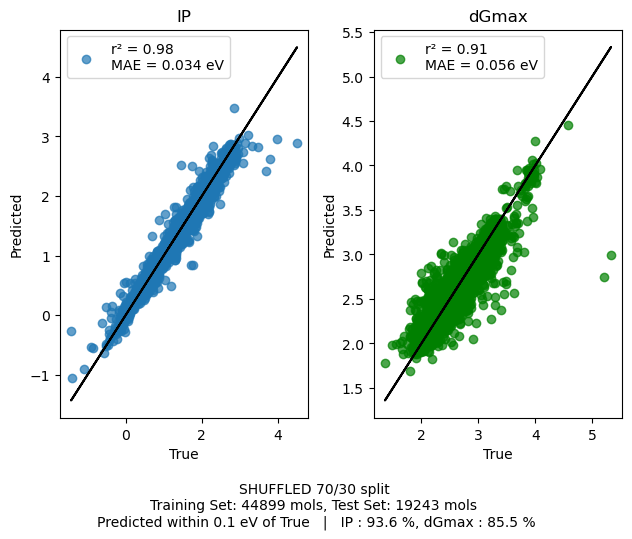

In [14]:
fig, ax = plt.subplots(1, 2)

label_ip = f'r\u00b2 = {round(r2_ip, 2)} \nMAE = {round(mae_ip, 3)} eV'
ax[0].scatter(y_test_ip, y_test_pred_ip, label=label_ip, alpha=0.7)
ax[0].plot(y_test_ip, y_test_ip, 'k')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted')
ax[0].set_title('IP')
ax[0].legend()

label_rdg = f'r\u00b2 = {round(r2_rdg, 2)} \nMAE = {round(mae_rdg, 3)} eV'
ax[1].scatter(y_test_rdg, y_test_pred_rdg, label=label_rdg, alpha=0.7, c='green')
ax[1].plot(y_test_rdg, y_test_rdg, 'k')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Predicted')
ax[1].set_title('dGmax')
ax[1].legend()

fig.tight_layout(pad=1.0)
text = fig.text(0.50, -0.1, 
                f'SHUFFLED 70/30 split \nTraining Set: {df_training.shape[0]} mols, Test Set: {df_test.shape[0]} mols \nPredicted within 0.1 eV of True   |   IP : {round(f_over_ip, 1)} %, dGmax : {round(f_over_rdg, 1)} %', 
                horizontalalignment='center', wrap=True )

# fig.suptitle(f'GPR Model fit to {df_training.shape[0]} mols, tested on {df_test.shape[0]} mols (70/30 split)') #, fontsize=20)

# fig, ax = plt.subplots()
# ax.scatter(y_test_ip, y_test_pred_ip, label='IP', alpha=0.7)
# ax.plot(y_test_ip, y_test_ip, 'k')
# ax.set_xlabel('True')
# ax.set_ylabel('Predicted')

In [ ]:
# D = np.load('/localdisk/bt308495/D.npy')

In [ ]:
# plt.title('Normalized model uncertainty, $\sigma / \sigma_{population}$ ')
# plt.hist(std_test_pred_ip/np.nanstd(df_test.IP.values), label='IP', density=True, bins=20)
# # plt.hist(stdrdg/np.nanstd(main_frame.dGmax.values), label='dGmax', density=True)
# plt.legend()

## Not Shuffled (Mimicking AL setting)

In [15]:
## Load data and OPTIMIZED model parameters
scratch_dir = '/localdisk/bt308495/'
scratch_fname = 'scratch_distance_matrix_70_30_NoShuffle'

with open(os.path.join(scratch_dir, scratch_fname, 'ML_IP.pckl'), 'rb') as f:
    ndf_training, ndf_test, nkip = pickle.load(f)

with open(os.path.join(scratch_dir, scratch_fname, 'ML_dGmax.pckl'), 'rb') as f:
    _, _, nkrdg = pickle.load(f)

In [16]:
## Gather test data
ndf_test = generate_ml_vectors(ndf_test)

nX_test = ndf_test.morgan_fp_bitvect.values
ny_test_ip = ndf_test.IP.values
ny_test_rdg = ndf_test.dGmax.values

In [ ]:
## Train/fit Models given params (~ 2 x 5min)
ngpr_ip = ML_model(ndf_training, 'IP', nkip, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))
ngpr_rdg = ML_model(ndf_training, 'dGmax', nkrdg, multiprocess=16, D_scratch_dir=os.path.join(scratch_dir, scratch_fname))

In [ ]:
## Storing models
nip_gpr_fname = 'gpr_ip.pckl'
nrdg_gpr_fname = 'gpr_dGmax.pckl'

# Save Models
# with open(os.path.join(scratch_dir, scratch_fname, nip_gpr_fname), 'wb') as f:
#     pickle.dump(ngpr_ip, f)

# with open(os.path.join(scratch_dir, scratch_fname, nrdg_gpr_fname), 'wb') as f:
#     pickle.dump(ngpr_rdg, f)

### Load models
with open(os.path.join(scratch_dir, scratch_fname, nip_gpr_fname), 'rb') as f:
    ngpr_ip = pickle.load(f)

with open(os.path.join(scratch_dir, scratch_fname, nrdg_gpr_fname), 'rb') as f:
    ngpr_rdg = pickle.load(f)

In [ ]:
# ny_test_pred_ip, nstd_test_pred_ip = ngpr_ip.predict(nX_test, return_std=True) **** SLOW (70mins)
ny_test_pred_ip = ngpr_ip.predict(nX_test)

# ny_test_pred_rdg, nstd_test_pred_rdg = ngpr_rdg.predict(nX_test, return_std=True) **** SLOW (70mins)
ny_test_pred_rdg = ngpr_rdg.predict(nX_test)

In [17]:
# with open(os.path.join(scratch_dir, scratch_fname, 'y_pred_nonshuffled.pckl'), 'wb') as f:
#     pickle.dump([ny_test_pred_ip, ny_test_pred_rdg], f)

with open(os.path.join(scratch_dir, scratch_fname, 'y_pred_nonshuffled.pckl'), 'rb') as f:
    ny_test_pred_ip, ny_test_pred_rdg = pickle.load(f)

In [18]:
## Evaluation Metrics
nmae_ip = mean_absolute_error(ny_test_ip, ny_test_pred_ip) # mae
nr2_ip = r2_score(ny_test_ip, ny_test_pred_ip) # pearson r2 score
# nevs_ip = explained_variance_score(ny_test_ip, ny_test_pred_ip) # explained variance

nmae_rdg = mean_absolute_error(ny_test_rdg, ny_test_pred_rdg) # mae
nr2_rdg = r2_score(ny_test_rdg, ny_test_pred_rdg) # pearson r2 score
# nevs_rdg = explained_variance_score(ny_test_rdg, ny_test_pred_rdg) # explained variance

In [19]:
# Residuals and performance
nr_ip = abs(ny_test_ip - ny_test_pred_ip)
nr_rdg = abs(ny_test_rdg - ny_test_pred_rdg)

nranked_r_ip = np.sort(nr_ip)
nranked_r_rdg = np.sort(nr_rdg)

nthresh = 0.1
nf_over_ip, nf_over_rdg = 100*np.sum(nr_ip < nthresh) / nr_ip.size, 100*np.sum(nr_rdg < nthresh) / nr_rdg.size

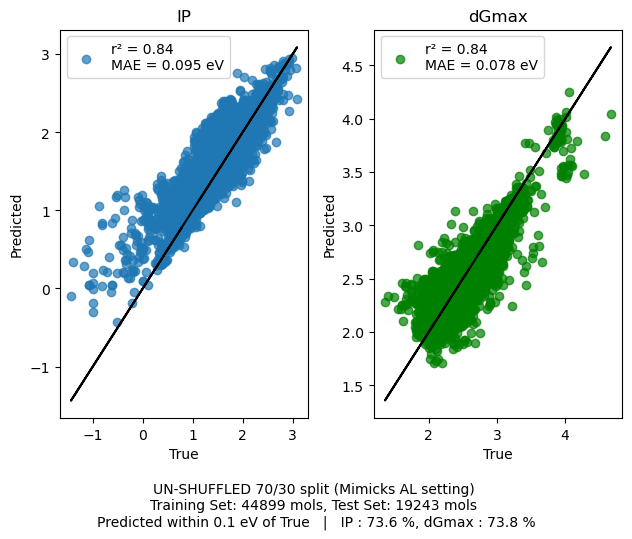

In [20]:
fig, ax = plt.subplots(1, 2)

nlabel_ip = f'r\u00b2 = {round(nr2_ip, 2)} \nMAE = {round(nmae_ip, 3)} eV'
ax[0].scatter(ny_test_ip, ny_test_pred_ip, label=nlabel_ip, alpha=0.7)
ax[0].plot(ny_test_ip, ny_test_ip, 'k')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted')
ax[0].set_title('IP')
ax[0].legend()

nlabel_rdg = f'r\u00b2 = {round(nr2_rdg, 2)} \nMAE = {round(nmae_rdg, 3)} eV'
ax[1].scatter(ny_test_rdg, ny_test_pred_rdg, label=nlabel_rdg, alpha=0.7, c='green')
ax[1].plot(ny_test_rdg, ny_test_rdg, 'k')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Predicted')
ax[1].set_title('dGmax')
ax[1].legend()

fig.tight_layout(pad=1.0)
text = fig.text(0.50, -0.1, 
                f'UN-SHUFFLED 70/30 split (Mimicks AL setting) \nTraining Set: {ndf_training.shape[0]} mols, Test Set: {ndf_test.shape[0]} mols \nPredicted within 0.1 eV of True   |   IP : {round(nf_over_ip, 1)} %, dGmax : {round(nf_over_rdg, 1)} %', 
                horizontalalignment='center', wrap=True )

In [21]:
from IPython.display import Image, display, HTML
# display(Image(filename='/home/btpq/bt308495/Thesis/IP_dGmax_Fit_Shuffled.png'))

image_path1 = '/home/btpq/bt308495/Thesis/IP_dGmax_Fit_Shuffled.png'
image_path2 = '/home/btpq/bt308495/Thesis/IP_dGmax_Fit_UnShuffled.png'


HTML(f"""
    <div class="row">
            <img src={image_path1} style="width:40%"> </img>
            <img src={image_path2} style="width:40%"> </img>
    </div>
    """)

In [22]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [23]:
ndf_test['IP_pred'] = ny_test_pred_ip
ndf_test['dGmax_pred'] = ny_test_pred_rdg
ndf_test['utility_function_pred'] = ndf_test['IP_pred'] - ndf_test['dGmax_pred']

In [ ]:
[(gen, d.shape[0]) for gen, d in df.groupby('generation')]

/tmp/ipykernel_23797/3973830811.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)
/tmp/ipykernel_23797/3483274750.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[indx].scatter(d.IP, d.IP_pred, c=cmap(i), alpha=0.7, label=label_gen)
/tmp/ipykernel_23797/3483274750.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or pro

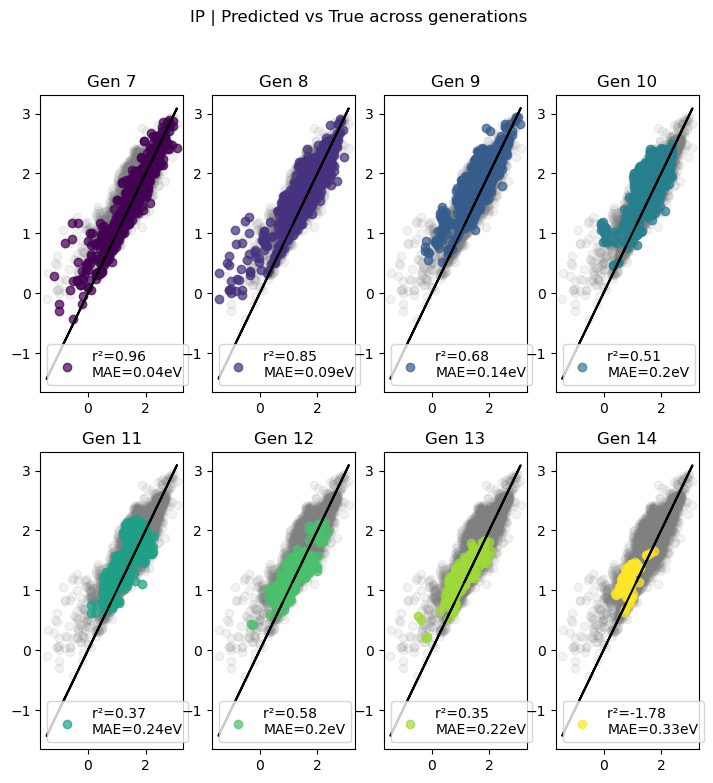

In [24]:
plt_grid = (2, 4)
cmap = get_cmap(len(ndf_test.generation.unique()), name='viridis')
fig, ax = plt.subplots(*plt_grid, figsize=[8.5, 8.5])
fig.suptitle('IP | Predicted vs True across generations')
ms_ip, rs_ip = [], []

for i, (gen, d) in enumerate(ndf_test.groupby('generation')):
    mae_gen = mean_absolute_error(d.IP, d.IP_pred) # mae
    r2_gen = r2_score(d.IP, d.IP_pred) # pearson r2 score
    ms_ip.append(mae_gen), rs_ip.append(r2_gen)

    label_gen = f'r\u00b2={round(r2_gen, 2)} \nMAE={round(mae_gen, 2)}eV'
    indx = np.unravel_index(i, plt_grid)
    ax[indx].set_title(f'Gen {gen}')
    ax[indx].scatter(ndf_test.IP, ndf_test.IP_pred, alpha=0.1, c='gray')
    ax[indx].scatter(d.IP, d.IP_pred, c=cmap(i), alpha=0.7, label=label_gen)
    ax[indx].plot(ndf_test.IP, ndf_test.IP, 'k')
    ax[indx].legend()

/tmp/ipykernel_23797/3973830811.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)
/tmp/ipykernel_23797/953238743.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[indx].scatter(d.dGmax, d.dGmax_pred, c=cmap(i), alpha=0.7, label=label_gen)
/tmp/ipykernel_23797/953238743.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or

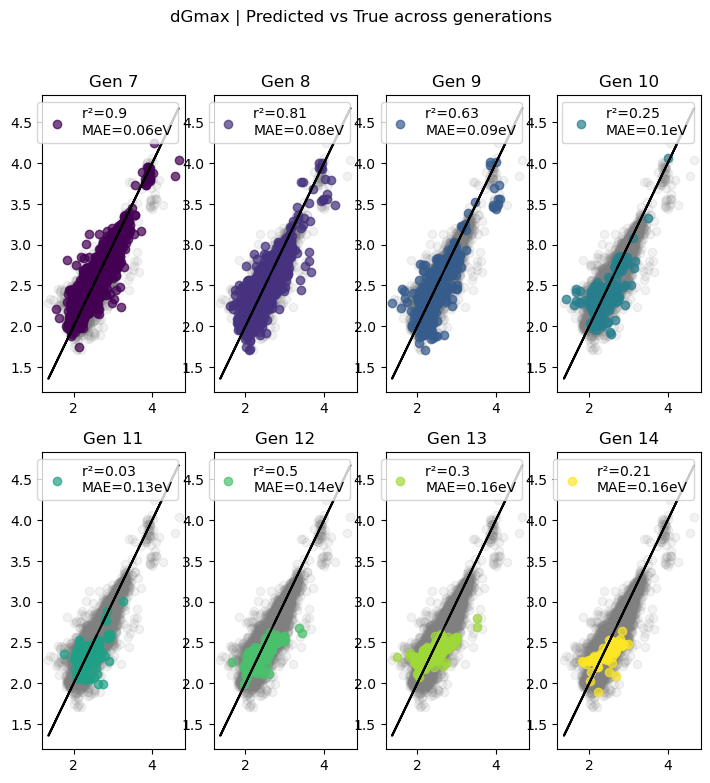

In [25]:
plt_grid = (2, 4)
cmap = get_cmap(len(ndf_test.generation.unique()), name='viridis')
fig, ax = plt.subplots(*plt_grid, figsize=[8.5, 8.5])
fig.suptitle('dGmax | Predicted vs True across generations')
ms_rdg, rs_rdg = [], []

for i, (gen, d) in enumerate(ndf_test.groupby('generation')):
    mae_gen = mean_absolute_error(d.dGmax, d.dGmax_pred) # mae
    r2_gen = r2_score(d.dGmax, d.dGmax_pred) # pearson r2 score
    ms_rdg.append(mae_gen), rs_rdg.append(r2_gen)

    label_gen = f'r\u00b2={round(r2_gen, 2)} \nMAE={round(mae_gen, 2)}eV'
    indx = np.unravel_index(i, plt_grid)
    ax[indx].set_title(f'Gen {gen}')
    ax[indx].scatter(ndf_test.dGmax, ndf_test.dGmax_pred, alpha=0.1, c='gray')
    ax[indx].scatter(d.dGmax, d.dGmax_pred, c=cmap(i), alpha=0.7, label=label_gen)
    ax[indx].plot(ndf_test.dGmax, ndf_test.dGmax, 'k')
    ax[indx].legend()

In [26]:
print('Percentage of Gen 7 in training data:')
print(round(100*(1 - ndf_test.loc[ndf_test.generation == 7].shape[0] / df.loc[df.generation == 7].shape[0]), 1), '%')

Percentage of Gen 7 in training data:
25.0 %


# Summary

Text(0.5, 0.98, 'Metrics vs Generation')

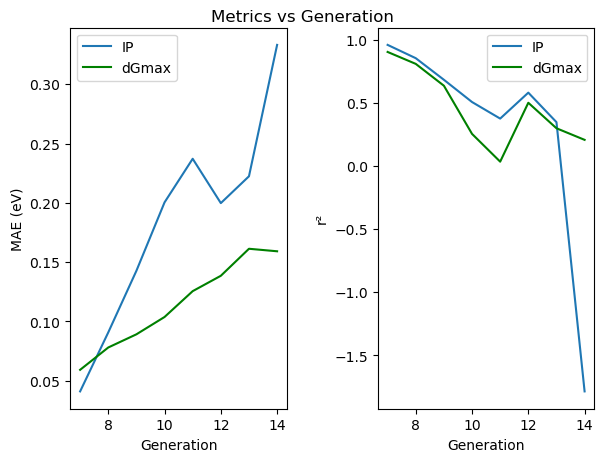

In [27]:
gens = ndf_test.generation.unique()
fig, ax = plt.subplots(1, 2)

ax[0].plot(gens, ms_ip, label='IP')
ax[0].plot(gens, ms_rdg, c='green', label='dGmax')
ax[0].set_xlabel('Generation')
ax[0].set_ylabel('MAE (eV)')
ax[0].legend()

ax[1].plot(gens, rs_ip, label='IP')
ax[1].plot(gens, rs_rdg, c='green', label='dGmax')
ax[1].set_xlabel('Generation')
ax[1].set_ylabel('r\u00b2')
ax[1].legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Metrics vs Generation')

In [28]:
out_of_gen_dftest = deepcopy(ndf_test.loc[ndf_test.generation > 7, ['IP', 'dGmax', 'IP_pred', 'dGmax_pred', 'utility_function', 'utility_function_pred']])

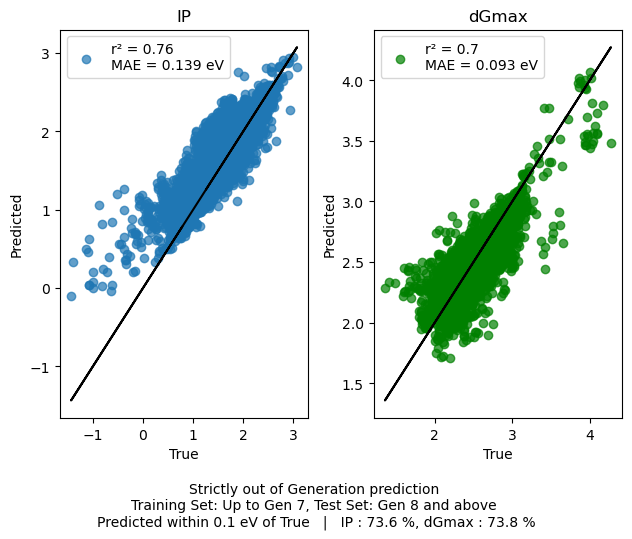

In [31]:
fig, ax = plt.subplots(1, 2)
r2_ip_o = r2_score(out_of_gen_dftest.IP, out_of_gen_dftest.IP_pred)
mae_ip_o = mean_absolute_error(out_of_gen_dftest.IP, out_of_gen_dftest.IP_pred)

r2_dGmax_o = r2_score(out_of_gen_dftest.dGmax, out_of_gen_dftest.dGmax_pred)
mae_dGmax_o = mean_absolute_error(out_of_gen_dftest.dGmax, out_of_gen_dftest.dGmax_pred)

nlabel_ip = f'r\u00b2 = {round(r2_ip_o, 2)} \nMAE = {round(mae_ip_o, 3)} eV'
ax[0].scatter(out_of_gen_dftest.IP, out_of_gen_dftest.IP_pred, label=nlabel_ip, alpha=0.7)
ax[0].plot(out_of_gen_dftest.IP, out_of_gen_dftest.IP, 'k')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted')
ax[0].set_title('IP')
ax[0].legend()

nlabel_ip = f'r\u00b2 = {round(r2_dGmax_o, 2)} \nMAE = {round(mae_dGmax_o, 3)} eV'
ax[1].scatter(out_of_gen_dftest.dGmax, out_of_gen_dftest.dGmax_pred, label=nlabel_ip, alpha=0.7, c='green')
ax[1].plot(out_of_gen_dftest.dGmax, out_of_gen_dftest.dGmax, 'k')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Predicted')
ax[1].set_title('dGmax')
ax[1].legend()

# nlabel_rdg = f'r\u00b2 = {round(nr2_rdg, 2)} \nMAE = {round(nmae_rdg, 3)} eV'
# ax[1].scatter(ny_test_rdg, ny_test_pred_rdg, label=nlabel_rdg, alpha=0.7, c='green')
# ax[1].plot(ny_test_rdg, ny_test_rdg, 'k')
# ax[1].set_xlabel('True')
# ax[1].set_ylabel('Predicted')
# ax[1].set_title('dGmax')
# ax[1].legend()

fig.tight_layout(pad=1.0)
text = fig.text(0.50, -0.1, 
                f'Strictly out of Generation prediction \nTraining Set: Up to Gen 7, Test Set: Gen 8 and above \nPredicted within 0.1 eV of True   |   IP : {round(nf_over_ip, 1)} %, dGmax : {round(nf_over_rdg, 1)} %', 
                horizontalalignment='center', wrap=True )

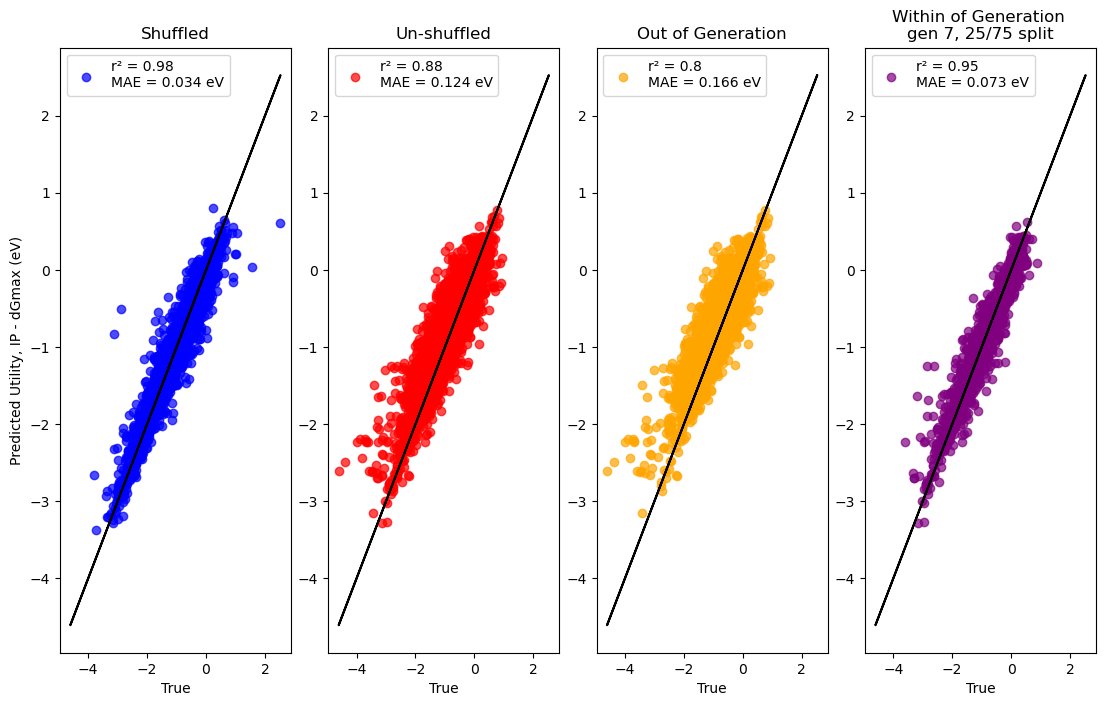

In [44]:
fig, ax = plt.subplots(1, 4, figsize=[11, 7])

r21 = r2_score(ndf_test.utility_function, ndf_test.utility_function_pred)
mae1 = mean_absolute_error(ndf_test.utility_function, ndf_test.utility_function_pred)

r22 = r2_score(out_of_gen_dftest.utility_function, out_of_gen_dftest.utility_function_pred)
mae2 = mean_absolute_error(out_of_gen_dftest.utility_function, out_of_gen_dftest.utility_function_pred)

ndf_test_7 = deepcopy(ndf_test.loc[ndf_test.generation == 7])
r23 = r2_score(ndf_test_7.utility_function, ndf_test_7.utility_function_pred)
mae3 = mean_absolute_error(ndf_test_7.utility_function, ndf_test_7.utility_function_pred)

nlabel = f'r\u00b2 = {round(r2_ip, 2)} \nMAE = {round(mae_ip, 3)} eV'
ax[0].scatter(df_test.utility_function, df_test.utility_function_pred, label=nlabel, alpha=0.7, c='blue')
ax[0].plot(df.utility_function, df.utility_function, 'k')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted Utility, IP - dGmax (eV)')
ax[0].set_title('Shuffled')
ax[0].legend()

nlabel = f'r\u00b2 = {round(r21, 2)} \nMAE = {round(mae1, 3)} eV'
ax[1].scatter(ndf_test.utility_function, ndf_test.utility_function_pred, label=nlabel, alpha=0.7, c='red')
ax[1].plot(df.utility_function, df.utility_function, 'k')
ax[1].set_xlabel('True')
# ax[1].set_ylabel('Predicted')
ax[1].set_title('Un-shuffled')
ax[1].legend()

nlabel_s = f'r\u00b2 = {round(r22, 2)} \nMAE = {round(mae2, 3)} eV'
ax[2].scatter(out_of_gen_dftest.utility_function, out_of_gen_dftest.utility_function_pred, label=nlabel_s, alpha=0.7, c='orange')
ax[2].plot(df.utility_function, df.utility_function, 'k')
ax[2].set_xlabel('True')
# ax[2].set_ylabel('Predicted')
ax[2].set_title('Out of Generation')
ax[2].legend()

nlabel_s = f'r\u00b2 = {round(r23, 2)} \nMAE = {round(mae3, 3)} eV'
ax[3].scatter(ndf_test_7.utility_function, ndf_test_7.utility_function_pred, label=nlabel_s, alpha=0.7, c='purple')
ax[3].plot(df.utility_function, df.utility_function, 'k')
ax[3].set_xlabel('True')
# ax[3].set_ylabel('Predicted')
ax[3].set_title('Within of Generation \ngen 7, 25/75 split')
ax[3].legend()

fig.tight_layout(pad=0.5)

### Conclusion
1. Model is pretty good
2. Its even better when its trained on samples from the same generation as the test case (of course...)
3. When enough data is present, IP is modelled more accurately than dGmax
4. Perhaps we can modify the AL algorithm to make it more robust:
At iteration 6 in the learning process, we produce generation 7, and we subsequently try to predict gen-7 properties using a model that is trained on molecules from gen-6 and below. Perhaps instead, at iteration 6, we can add some random gen-7 molecules to the training set, and use that model to predict the rest of the gen-7 properties.

### TODO
1. Data mining to uncover structure-property relationships
2. Perhaps this can motivate new morphing operations

---

### Fitting GPR using gpr_model.py

In [ ]:
from photocatalysis.learners_treesearch import generate_ml_vectors
from sklearn.model_selection import train_test_split

from scipy.linalg import cholesky, cho_solve, solve_triangular

In [ ]:
df = generate_ml_vectors(df)
df_training, df_test = train_test_split(df, test_size=0.3, random_state=42)

X_train = df_training.morgan_fp_bitvect.values
y_train = df_training.IP.values

In [ ]:
# Prep data
_y_train_mean = np.mean(y_train, axis=0)
_y_train_std = np.std(y_train, axis=0)
y_train = (y_train - _y_train_mean) / _y_train_std
y_train = np.array(y_train, ndmin=2).T

In [ ]:
kernel_params = {'C':1., 'length_scale':1., 'sigma_n':0.1}

In [ ]:
#### 1m3s (16 core)
#### 59s (42 core)
# Load distance matrix
D = np.load('/localdisk/bt308495/scratch_distance_matrix_80_20/D_mat.npy')

# construct kernel with noise
white_noise = np.eye(len(X_train),len(X_train)) * kernel_params['sigma_n']**2
K = kernel_params['C']**2*(1.-D)
K += white_noise

# Cholesky decomposition
L = cholesky(K, lower=True)

In [ ]:
### 1m28s (16 core)
### 1m5s (42 core)
alpha = cho_solve((L, True), y_train)
L_inv = solve_triangular(L.T, np.eye(L.shape[0]))

In [ ]:
# np.save('/localdisk/bt308495/D.npy', D)
# np.save('/localdisk/bt308495/K.npy', K)
# np.save('/localdisk/bt308495/L.npy', L)
# np.save('/localdisk/bt308495/L_inv.npy', L_inv)

D = np.load('/localdisk/bt308495/D.npy')
K = np.load('/localdisk/bt308495/K.npy')
L = np.load('/localdisk/bt308495/L.npy')
L_inv = np.load('/localdisk/bt308495/L_inv.npy')

In [ ]:
alpha = cho_solve((L, True), y_train)

In [ ]:
K_gradient = np.dstack(( (np.full((K.shape[0], K.shape[1]), 2*kernel_params['C'],
                            dtype=np.array(kernel_params['C']).dtype)*K)[:, :, np.newaxis],
                           ( kernel_params['C']**2* np.zeros(K.shape) )[:, :, np.newaxis], 
                           (np.eye(len(X_train), len(X_train)) * 2*kernel_params['sigma_n'])[:, :, np.newaxis]
                        ))

In [ ]:
### 1m53s (32 core)
### 1m45.7 (42 core)
L_inv_T = L_inv.copy().T
K_inv = L_inv.dot(L_inv_T)

In [ ]:
print('Log Marginal Likehood determination')
log_likelihood_dims = -0.5 * np.einsum("ik,ik->k", y_train, alpha)
log_likelihood_dims -= np.log(np.diag(L)).sum()
log_likelihood_dims -= len(X_train) / 2 * np.log(2 * np.pi)
log_likelihood = log_likelihood_dims.sum(-1)  # sum over dimensions


tmp = np.einsum("ik,jk->ijk", alpha, alpha)  # k: output-dimension
tmp -= cho_solve((L, True), np.eye(len(X_train)))[:, :, np.newaxis]

In [ ]:
log_likelihood_gradient_dims = 0.5 * np.einsum("ijl,jik->kl", tmp, K_gradient)
log_likelihood_gradient = log_likelihood_gradient_dims.sum(-1)
output = float(log_likelihood), log_likelihood_gradient

------

# GPR MODEL

In [ ]:
test_size = 0.95
random_state = 42

In [ ]:
from photocatalysis.learners_treesearch import generate_ml_vectors, get_ML_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

In [ ]:
### With np.arrays()
# X = generate_ml_vectors(df).morgan_fp_bitvect.values

# Y_IP = df.IP.values
# Y_dGmax = df.dGmax.values

# X_train_IP, X_test_IP, y_train_IP, y_test_IP = train_test_split(X, Y_IP, test_size=test_size, random_state=random_state)
# X_train_dGmax, X_test_dGmax, y_train_dGmax, y_test_dGmax = train_test_split(X, Y_dGmax, test_size=test_size, random_state=random_state)

In [ ]:
### With pd.DataFrames()
df_training, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
df_test = generate_ml_vectors(df_test)

In [ ]:
df.plot(y='utility_function', kind='hist', bins=40)

----

In [ ]:
start = time.perf_counter()
gpr_ip, xtrain_ip, kip = get_ML_model(df_training, 'IP', multiprocess=1, D_scratch_dir='/run/user/1308495/scratch_distance_matrix', niter_local=1)
print('IP Fitting Took:', time.perf_counter() - start)

In [ ]:
main_scratch = '/run/user/1308495'
save_path = os.path.join(main_scratch, 'ML_IP_95_1.pckl')

In [ ]:
with open(save_path, 'wb') as p:
    pickle.dump([gpr_ip, xtrain_ip, kip], p)

In [ ]:
with open(save_path, 'rb') as p:
    out = pickle.load(p)

In [ ]:
X_test = df_test.morgan_fp_bitvect.values

In [ ]:
yip, stdip = gpr_ip.predict(X_test, return_std=True)

---

In [ ]:
start = time.perf_counter()
gpr_rdg, xtrain_rdg, krdg = get_ML_model(df_training, 'dGmax', multiprocess=1, D_scratch_dir='/run/user/1308495/scratch_distance_matrix', niter_local=1)
print('RDG Fitting Took:', time.perf_counter() - start)